Recommender System Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Intitialize Spark Session

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, lag
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder.appName("RecommendationSystemEDA").getOrCreate()

In [2]:
from google.colab import files
upoaded = files.upload()

Saving transactions_data.csv to transactions_data.csv


#### Review Transactions Data

In [5]:
# Load dataset
df = spark.read.csv('transactions_data.csv', header=True, inferSchema=True)

# Preview dataset
df.show(5)

+--------------+-----------+----------+-------------------+------------+--------------------+--------+------+----------------+------+---+--------+------------------+------------------+----------+-------+
|transaction_id|customer_id|      date|               time|product_name|            category|quantity| price|discount_applied|rating|age|location|purchase_frequency|last_purchase_date|session_id| device|
+--------------+-----------+----------+-------------------+------------+--------------------+--------+------+----------------+------+---+--------+------------------+------------------+----------+-------+
|             1|      C1041|2024-10-20|2025-08-08 09:33:49|       Flour|      Pantry Staples|       3| 26.12|             0.0|     1| 18|   Paris|               Low|        2024-12-20|     S1771| Mobile|
|             2|      C1006|2025-03-01|2025-08-08 19:12:14|     Chicken|      Meat & Seafood|       4|313.48|             0.0|     5| 40|New York|              High|        2024-04-07|

In [7]:
# Print Schema
df.printSchema()

root
 |-- transaction_id: integer (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- discount_applied: double (nullable = true)
 |-- rating: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- purchase_frequency: string (nullable = true)
 |-- last_purchase_date: date (nullable = true)
 |-- session_id: string (nullable = true)
 |-- device: string (nullable = true)



In [9]:
# Chech the number of transactions and unique customers
print(f"Total Transactions: {df.count()}")
print(f"Unique Customers: {df.select('customer_id').distinct().count()}")

Total Transactions: 100000
Unique Customers: 50


#### Identify Purchase Patterns

In [11]:
# Top 10 selling products
n = 10
top_n_products = (
    df.groupBy('product_name')
    .agg(count('transaction_id').alias('purchase_count'))
    .orderBy(desc('purchase_count'))
)

top_n_products.show(n)

+-----------------+--------------+
|     product_name|purchase_count|
+-----------------+--------------+
|Laundry Detergent|          3392|
|        Dish Soap|          3388|
|     Paper Towels|          3346|
|     Frozen Pizza|          3318|
|        Ice Cream|          3300|
|Frozen Vegetables|          3252|
|           Salmon|          2592|
|       Toothpaste|          2575|
|        Croissant|          2564|
|           Cheese|          2556|
+-----------------+--------------+
only showing top 10 rows



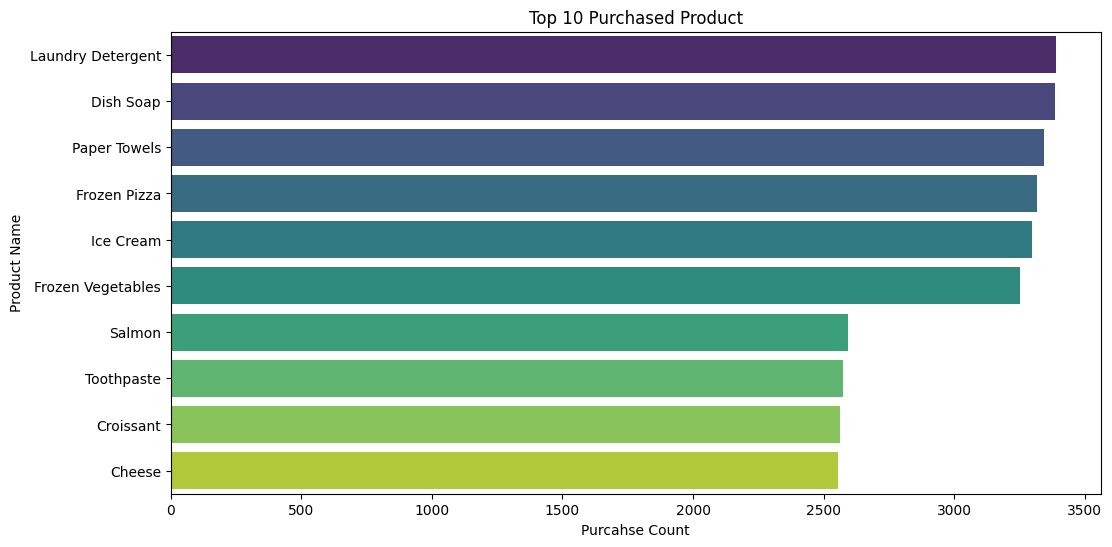

In [12]:
# Convert to pandas for visualization
top_n_prodcuts_pdf = top_n_products.limit(n).toPandas()

# Plot the top-selling products
plt.figure(figsize=(12, 6))
sns.barplot(data=top_n_prodcuts_pdf, x='purchase_count', y='product_name', palette='viridis', hue='product_name', legend=False)
plt.xlabel('Purcahse Count')
plt.ylabel('Product Name')
plt.title(f'Top {n} Purchased Product')
plt.show()

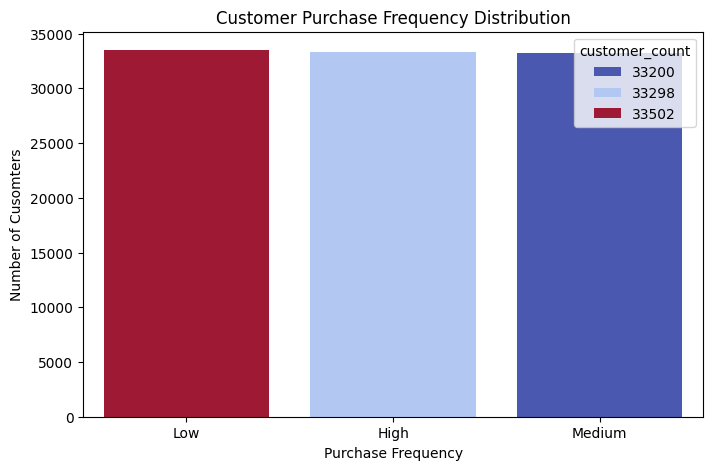

In [17]:
#### Analyze Frequency of Repurchases
repurchase_freq = (
    df.groupBy('purchase_frequency')
    .agg(count('customer_id').alias('customer_count'))
    .orderBy(desc('customer_count'))
    )

# Convert to Pandas
repurchase_freq_pdf = repurchase_freq.toPandas()

# Plot Repurchase Frequency
plt.figure(figsize=(8, 5))
sns.barplot(data=repurchase_freq_pdf, x='purchase_frequency', y='customer_count', palette='coolwarm', hue='customer_count', legend=True)
plt.xlabel('Purchase Frequency')
plt.ylabel('Number of Cusomters')
plt.title('Customer Purchase Frequency Distribution')
plt.show()

#### Analyze Product co-occurence

In [24]:
# which products are frequently bought together

window_spec = Window.partitionBy("customer_id").orderBy("date")
df = df.withColumn("previous_product", lag("product_name").over(window_spec))

product_pairs = df.groupBy("previous_product", "product_name").agg(count("*").alias("co_occurrence_count"))
product_pairs.orderBy(desc("co_occurrence_count")).show(10)

+-----------------+-----------------+-------------------+
| previous_product|     product_name|co_occurrence_count|
+-----------------+-----------------+-------------------+
|Frozen Vegetables|        Ice Cream|                132|
|     Paper Towels|Laundry Detergent|                130|
|        Dish Soap|Laundry Detergent|                127|
|        Ice Cream|     Paper Towels|                124|
|     Frozen Pizza|Laundry Detergent|                124|
|        Ice Cream|     Frozen Pizza|                124|
|        Ice Cream|Laundry Detergent|                122|
|        Dish Soap|        Dish Soap|                119|
|        Dish Soap|     Paper Towels|                118|
|     Frozen Pizza|Frozen Vegetables|                117|
+-----------------+-----------------+-------------------+
only showing top 10 rows



#### Purchase Trends Over Time

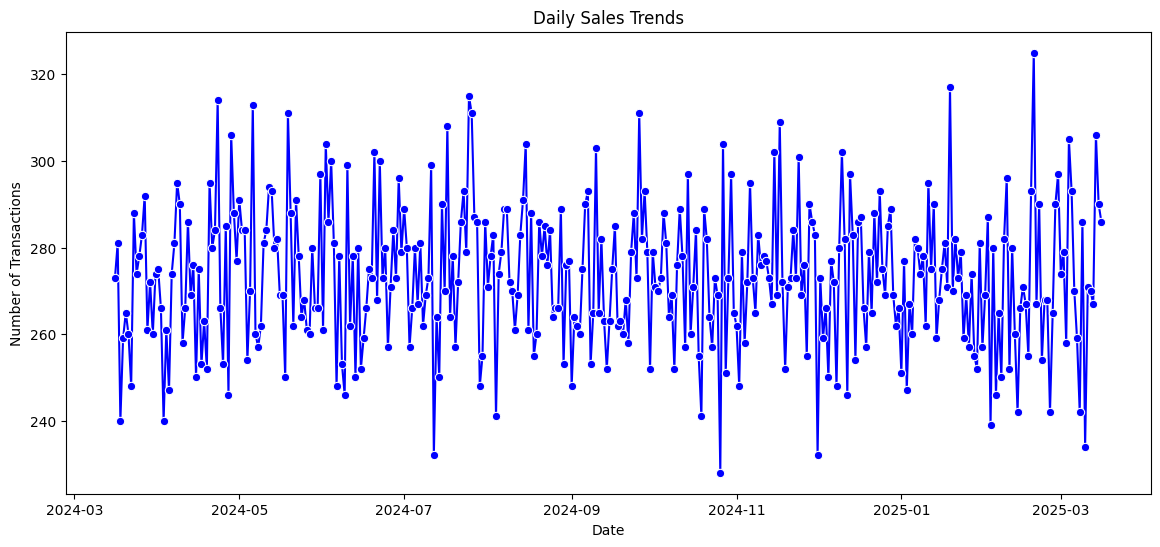

In [30]:
# Number of transactions per day
daily_sales = df.groupBy('date').agg(count('transaction_id').alias('daily_sales')).orderBy('date')

# Convert to pandas
daily_sales_pdf = daily_sales.toPandas()

# Plot daily sales trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales_pdf, x='date', y='daily_sales', marker='o', color='b')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Sales Trends')
plt.show()

In [32]:
# Stop Spark session
spark.stop()